# Pr-Intern Tests

In [1]:
from huggingface_hub import login
import matplotlib.pyplot as plt
import torch

from test_experiments.test_utils import *
login(
    token="..."
)

## Experiment Configurations
Define different experimental setups with various model configurations

In [2]:
experiments={
    # 'exp0':{'language':False,'vision':False,'expert':False,'lora':False,'path':''},
    'exp1':{'language':True,'vision':True,'expert':False,'lora':False,'path':'ex.1'},
    'exp2':{'language':False,'vision':False,'expert':True,'lora':False,'path':'ex.2'},
    'exp3':{'language':True,'vision':False,'expert':True,'lora':False,'path':'ex.3'},
    'exp4':{'language':False,'vision':True,'expert':True,'lora':False,'path':'ex.4'},
    'exp5':{'language':True,'vision':True,'expert':True,'lora':False,'path':'ex.5'},
    'exp6':{'language':True,'vision':True,'expert':False,'lora':True,'path':'ex.6'},
    'exp7':{'language':True,'vision':True,'expert':True,'lora':True,'path':'ex.7'}
}

## Model / datasets loader

### Model

In [15]:
def load_and_prepare_model(experiment):
    
    model, processor, vision_expert = load_model_and_processor(
        experiment,
    )

    model.eval()
    return model, processor, vision_expert

### Image-Caption dataset

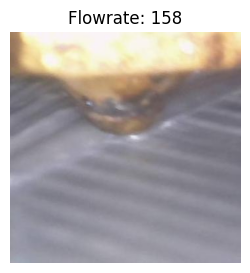

In [16]:
dataset = load_test_dataset(test_samples=500)
dataloader_our_dataset = batchify(dataset, batch_size=8)

# Get first sample and display image
sample = dataset[0]

# Visualize the image
import matplotlib.pyplot as plt
from PIL import Image

# Load image from path
img = Image.open(sample['full_img_path'])

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.title(f"Flowrate: {sample['flow_rate']}")
plt.axis('off')
plt.show()


### Flickr30K dataset

A man is laughing with his hand up in the air and a little boy is watching him and laughing.
A man in a striped blue shirt is playing with a little boy next to his crib.
A man spending time with his toddler son, who is holding a white cup.
A man in a striped shirt is playing with a baby and making him laugh.
A smiling man plays with a baby.


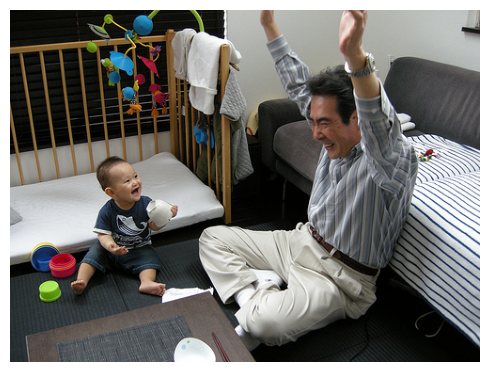

In [17]:
from datasets import load_dataset
import random

# Convert flickr30k to batches
def batchify_flickr(dataset, batch_size=8):
    batch = []
    for sample in dataset:
        batch.append(sample)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:  # Yield remaining samples if any
        yield batch

# Load the Flickr30K dataset
flickr30k = load_dataset("nlphuji/flickr30k", streaming=True, split='test').shuffle(seed=42).take(100)
dataloader_flickr = list(batchify_flickr(flickr30k, batch_size=8))

# Set up the figure with two subplots side by side
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

# Get a random pair
sample_pair = next(iter(flickr30k))
for caption in sample_pair['caption']:
    print(f"\033[3m{caption}\033[0m")

# Display the image
ax1.imshow(sample_pair['image'])
ax1.axis('off')

plt.tight_layout()
plt.show()

### Question-Answer dataset

In [15]:
from datasets import load_dataset

# Load the SQuAD dataset
squad_data = load_dataset('squad', streaming=True, split='validation').shuffle(seed=42).take(100)

# Convert flickr30k to batches
def batchify_squad(dataset, batch_size=8):
    batch = []
    for sample in dataset:
        batch.append(sample)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:  # Yield remaining samples if any
        yield batch

dataloader_squad = list(batchify_squad(squad_data, batch_size=8))

# Get a random QA pair from SQuAD
sample_qa = next(iter(squad_data))

print("Context:", sample_qa['context'])
print("\nQuestion:", sample_qa['question']) 
print("\nAnswer:", sample_qa['answers']['text'][0])


Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game. The Super Bowl 50 halftime show was headlined by the British rock group Coldplay with special guest performers Beyoncé and Bruno Mars, who headlined the Super Bowl XLVII and Super Bowl XLVIII halftime shows, respectively. It was the third-most watched U.S. broadcast ever.

Question: Who was the main performer at this year's halftime show?

Answer: Coldplay


## Answer Generation

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Validating: exp3


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Loading vision expert
Model loaded from /home/cm2161/rds/hpc-work/


Processing domain batches:   0%|               | 0/63 [00:00<?, ?it/s]

step validation:  17.181720733642578


/tmp/ipykernel_735627/353542903.py:58: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


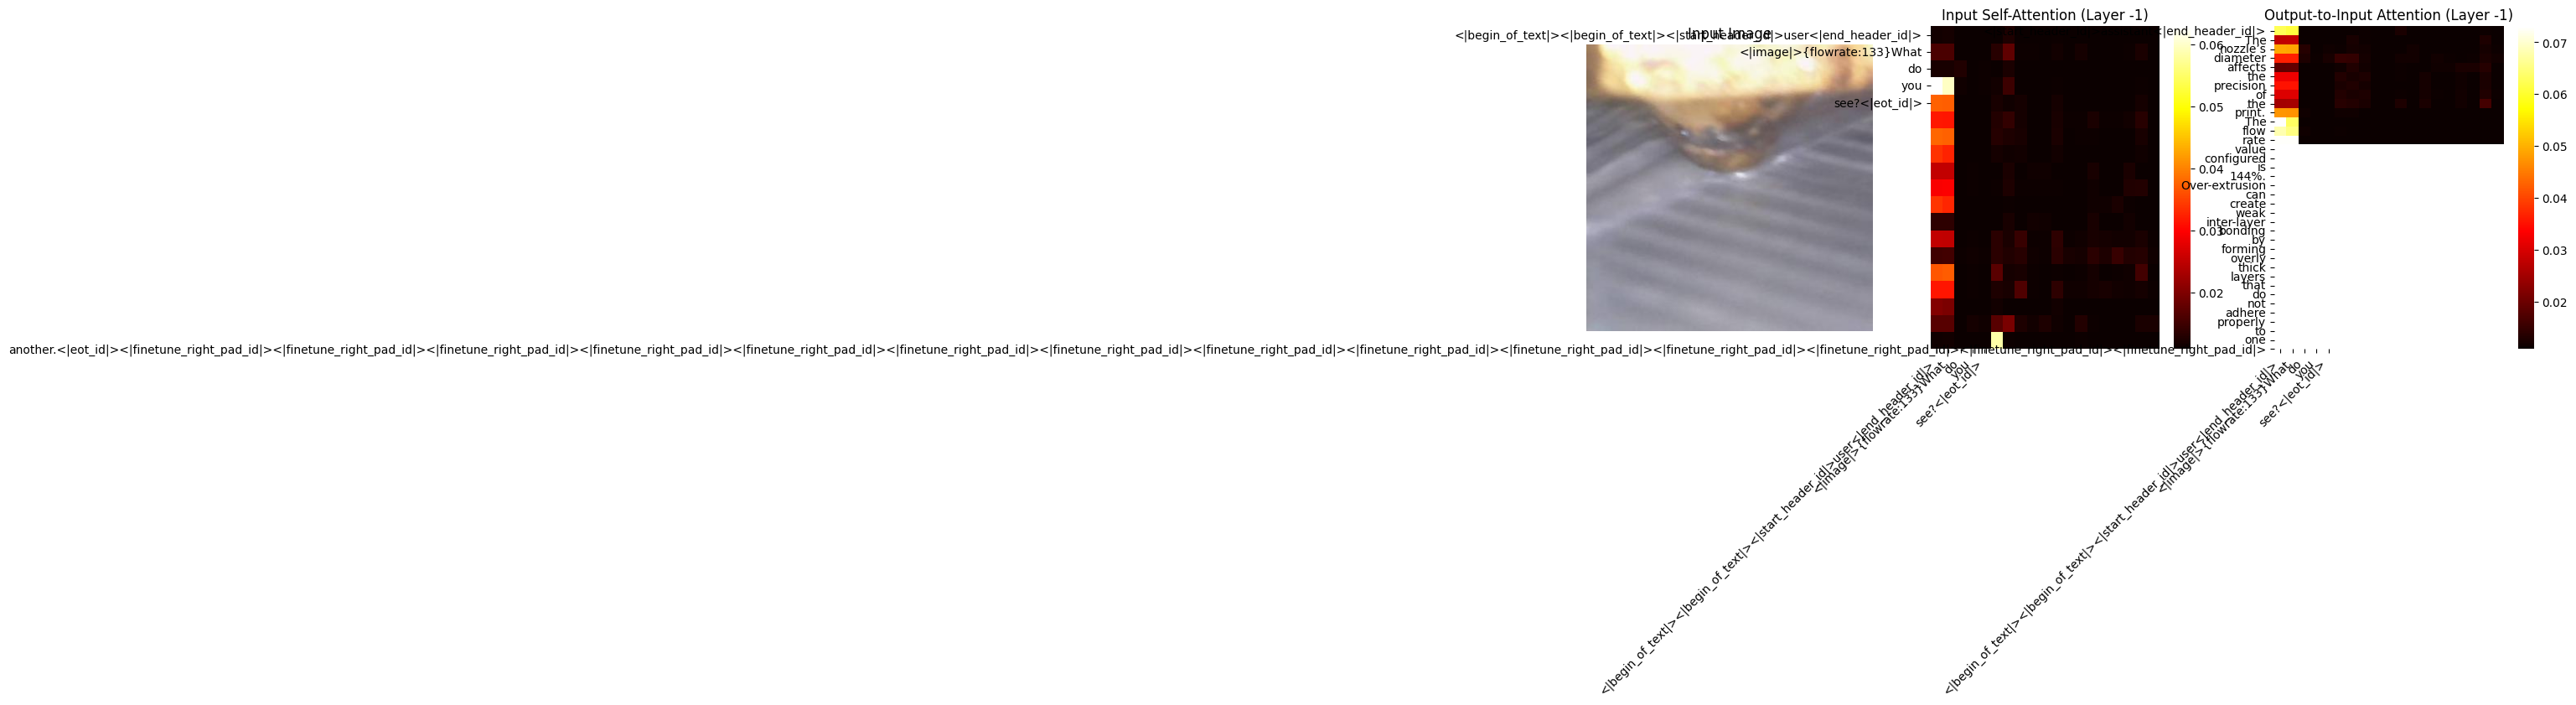

/tmp/ipykernel_735627/353542903.py:58: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


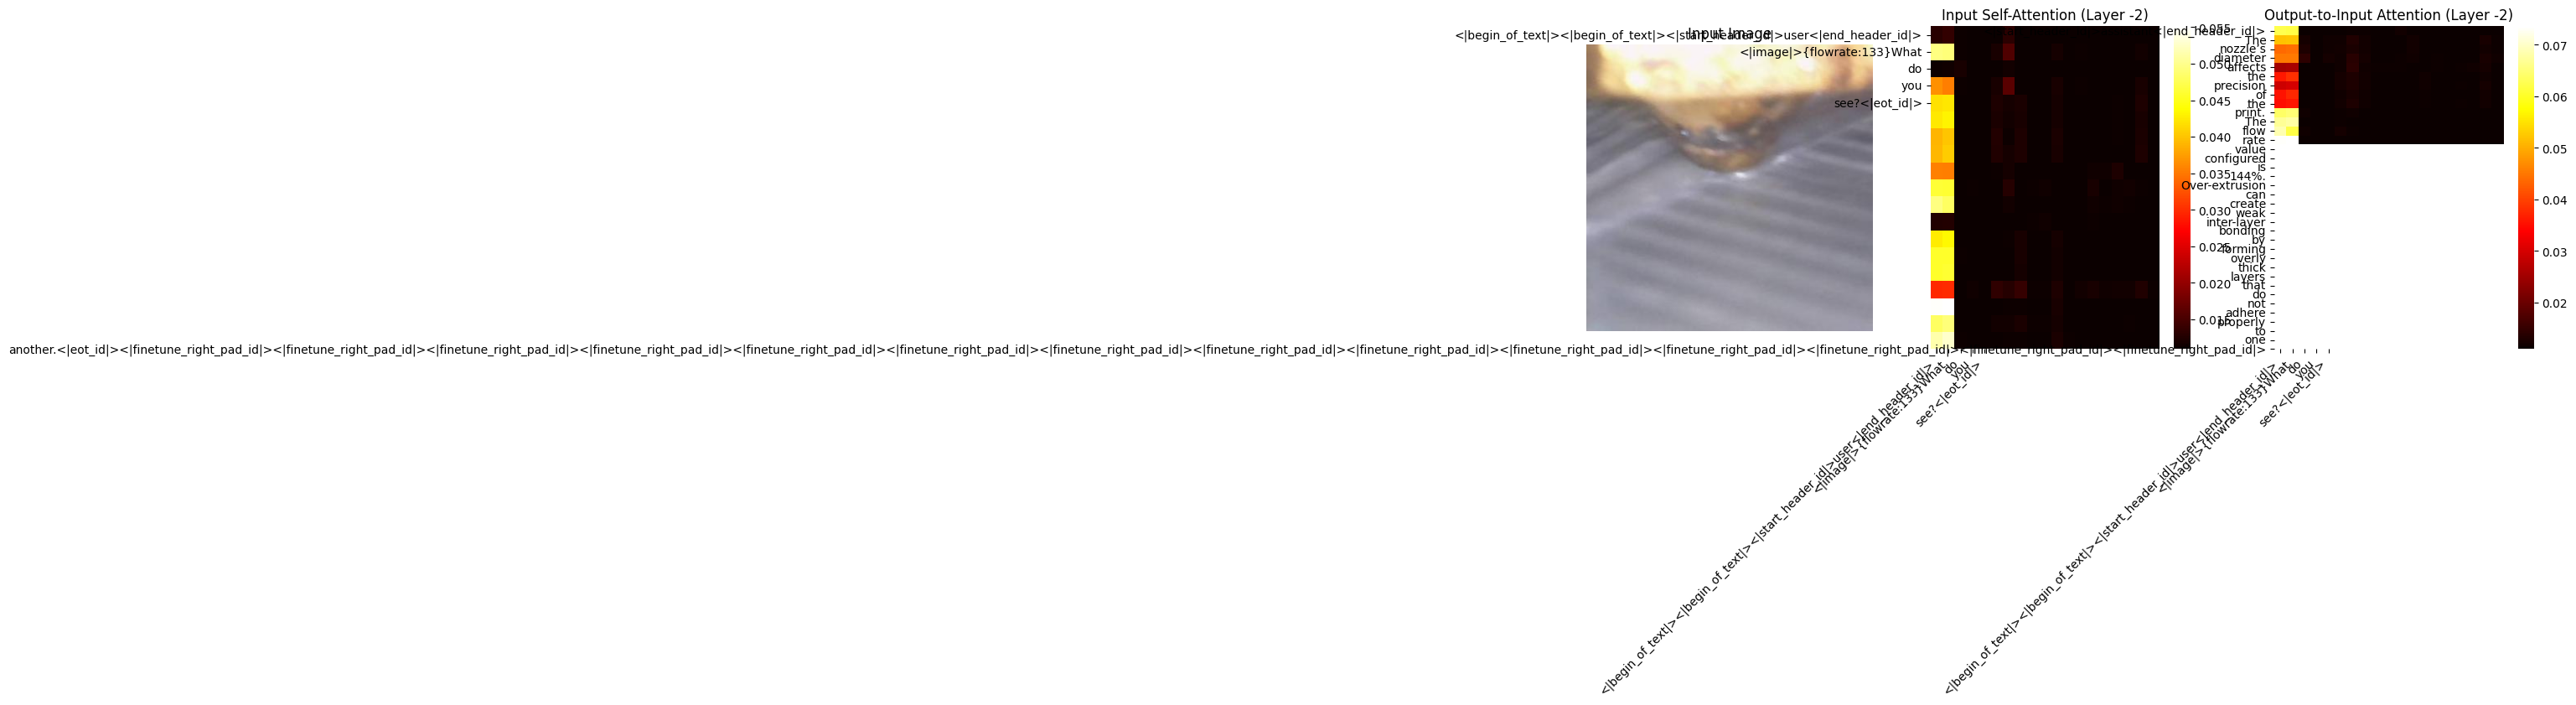

/tmp/ipykernel_735627/353542903.py:58: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


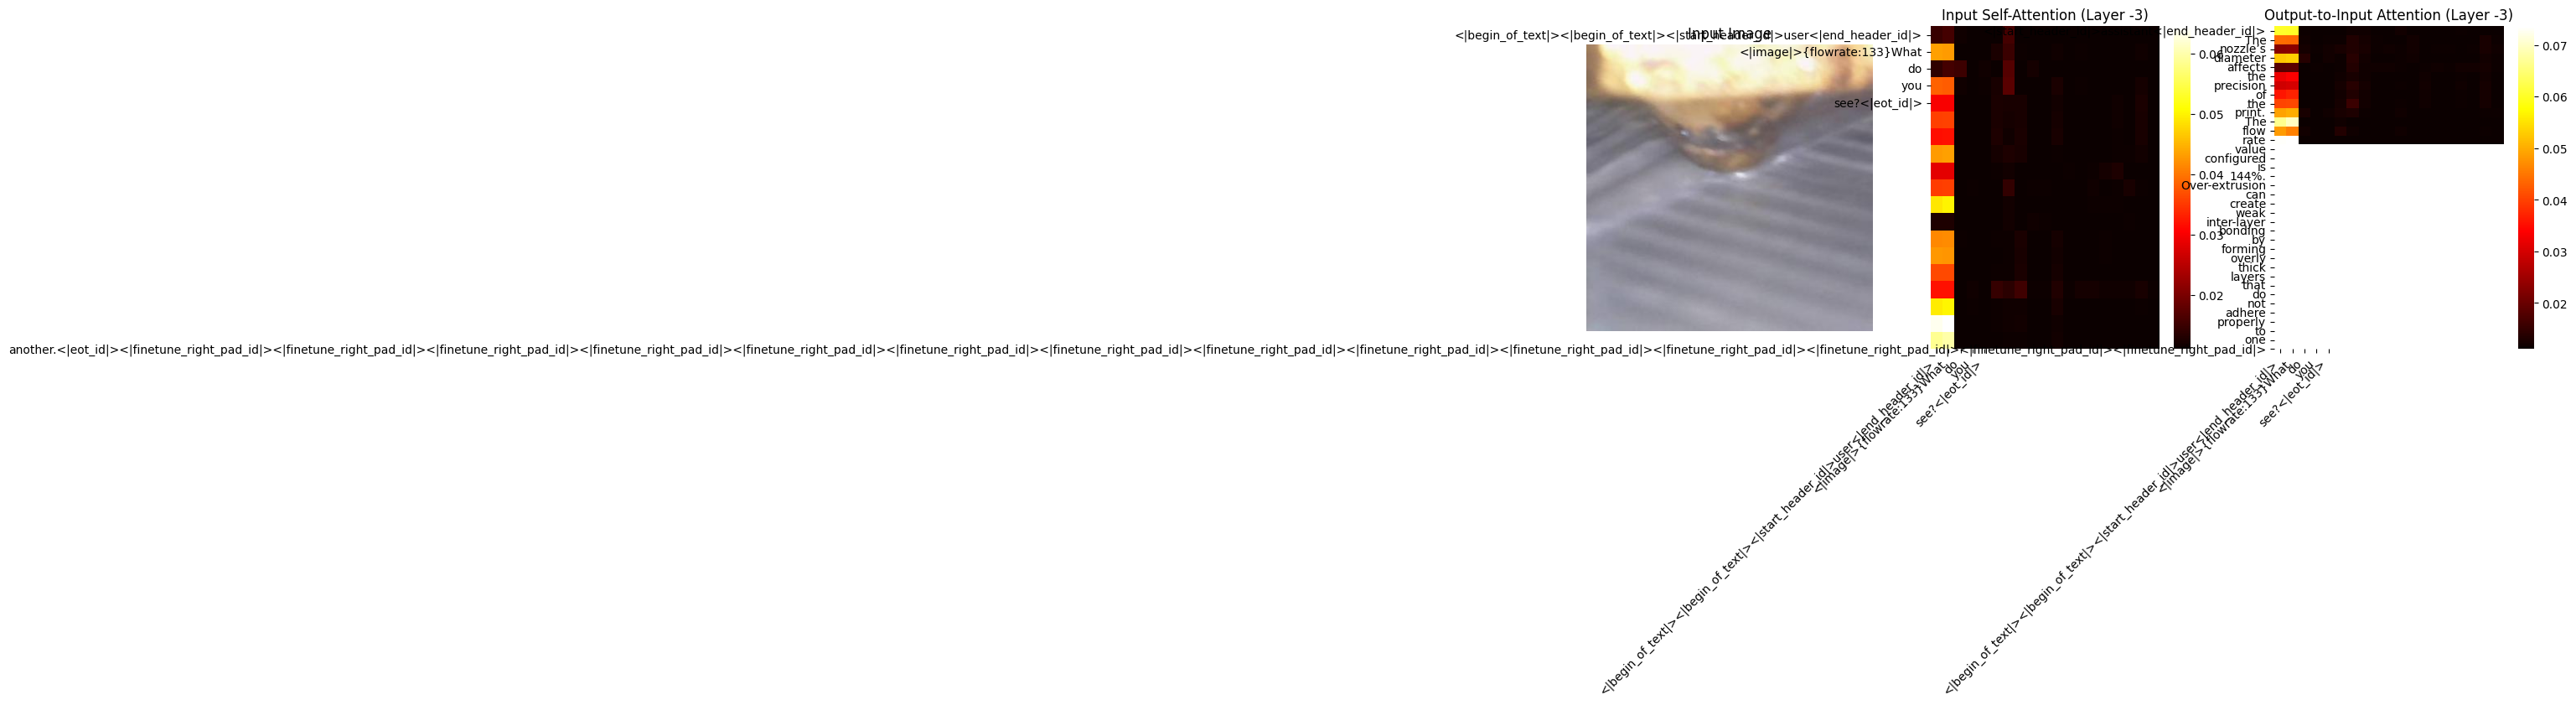

Processing domain batches:   0%|               | 0/63 [00:13<?, ?it/s]


In [33]:
# Store results for each experiment
experiment_results = {}

from tqdm import tqdm

for key, value in experiments.items():
    print(f"Validating: {key}")

    # Load and prepare model components
    model, processor, vision_expert = load_and_prepare_model(value)

    # Test 1: Domain-specific dataset evaluation
    experiment_answers = []
    experiment_flow_rates = [] 
    numerical_values = []

    for batch in tqdm(dataloader_our_dataset, desc="Processing domain batches"):
        with torch.no_grad():
            # Prepare batch
            batch_collated = val_collate_fn(
                batch, 
                processor,
                vision_expert if vision_expert else False
            ).to(model.device)

            # Generate outputs
            outputs = model.generate(
                **batch_collated,
                max_new_tokens=1024,
                temperature=0.2
            )

            # Process results
            decoded_outputs = map(processor.decode, outputs)
            answers = answer_extractor(decoded_outputs)
            flow_rates = [item["flow_rate"] for item in batch]

            # Store results
            experiment_answers.extend(answers)
            experiment_flow_rates.extend(flow_rates)
            numerical_values = extract_fr(experiment_answers)

            # Save domain results
            results_df = pd.DataFrame({
                'y': experiment_flow_rates,
                'y_class': [-1 if y < 90 else (1 if y > 110 else 0) for y in experiment_flow_rates],
                'y_hat': extract_fr(experiment_answers),
                'y_class_hat': [-1 if y < 90 else (1 if y > 110 else 0) for y in extract_fr(experiment_answers)],
                'answers': experiment_answers,
            })
            results_df.to_csv(f'experiments/caxton_experiment_results_{key}.csv', 
                            index=True, 
                            index_label='image_id')

    # Test 2: Vision overfitting evaluation 
    vision_answers = []
    vision_answers_original = []
    
    for batch in tqdm(dataloader_flickr, desc="Processing vision overfitting batches"):
        with torch.no_grad():
            # Prepare batch
            batch_collated = val_collate_fn_flickr(batch, processor).to(model.device)

            # Generate outputs
            outputs = model.generate(
                **batch_collated,
                max_new_tokens=1024,
                temperature=0.2
            )

            # Process results
            decoded_outputs = map(processor.decode, outputs)
            answers = answer_extractor(decoded_outputs)
            original_captions = [item['caption'] for item in batch]

            # Store results
            vision_answers.extend(answers)
            vision_answers_original.extend(original_captions)

            # Save vision results
            results_df = pd.DataFrame({
                'answers': vision_answers,
                'captions': vision_answers_original,
            })
            results_df.to_csv(f'experiments/flickr_experiment_results_{key}.csv',
                            index=True,
                            index_label='image_id')

    # Test 3: Language overfitting evaluation
    qa_answers = []
    qa_answers_original = []

    for batch in tqdm(dataloader_squad, desc="Processing language overfitting batches"):

        with torch.no_grad():
            # Prepare batch
            batch_collated = val_collate_fn_squad(batch, processor).to(model.device)

            # Generate outputs
            outputs = model.generate(
                **batch_collated,
                max_new_tokens=1024,
                temperature=0.2
            )

            # Process results
            decoded_outputs = map(processor.decode, outputs)
            answers = answer_extractor(decoded_outputs)
            original_answers = [item['answers']['text'] for item in batch]

            # Store results
            qa_answers.extend(answers)
            qa_answers_original.extend(original_answers)

            # Save QA results
            results_df = pd.DataFrame({
                'answers': qa_answers,
                'original_answers': qa_answers_original,
            })
            results_df.to_csv(f'experiments/squad_experiment_results_{key}.csv',
                            index=True,
                            index_label='question_id')

## Evaluation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Create a single figure for all box plots
mm_to_inches = 0.0393701
fig_size_inches = 33 * mm_to_inches

# Create a single figure for all box plots
plt.figure(figsize=(fig_size_inches, fig_size_inches), dpi=1200)

# Store errors for all experiments
all_errors = []
labels = []

for key in experiments.keys():
    # Load results
    results_df = pd.read_csv(f'/home/cm2161/Documents/llama-manufacturing/pr-intern/control_experiments/caxton/caxton_experiment_results_{key}.csv')
    
    if 'y' in results_df.columns and 'y_hat' in results_df.columns:
        errors = np.abs(results_df['y_hat'] - results_df['y'])
        print(np.mean(errors))
        all_errors.append(errors)
        labels.append(f"ex.{key[-1]}")

# # Create box plots with custom style
# box_props = dict(
#     boxprops=dict(facecolor='lightgrey', color='black', linewidth=0.5),
#     whiskerprops=dict(color='black', linewidth=0.5),
#     capprops=dict(color='black', linewidth=0.5),
#     medianprops=dict(color='black', linewidth=0.5),
#     flierprops=dict(
#         marker='o',
#         markerfacecolor='black',
#         markeredgecolor='none',
#         alpha=0.1,
#         markersize=2,
#         linewidth=0.1
#     ),
#     patch_artist=True,
# )

# # Create box plots side by side
# plt.boxplot(all_errors, labels=labels, vert=False, **box_props)

# # Remove all spines and axes
# ax = plt.gca()
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # Remove all ticks and labels
# ax.set_xticks([])
# ax.set_yticks([])

# # Set y-axis limits and invert
# plt.xlim(-20, 300)
# plt.gca().invert_yaxis()

# ax.set_xticks([0, 50, 100, 150, 200, 250, 300])
# ax.set_xticklabels([])  # Remove x-axis labels
# ax.tick_params(axis='x', length=0)  # Remove tick marks
# ax.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1, zorder=0)
# ax.set_axisbelow(True)

# # Remove any padding
# plt.tight_layout(pad=0)
# plt.show()

82.92
17.522
17.298
17.622
17.782
61.946
19.066


<Figure size 1559.06x1559.06 with 0 Axes>

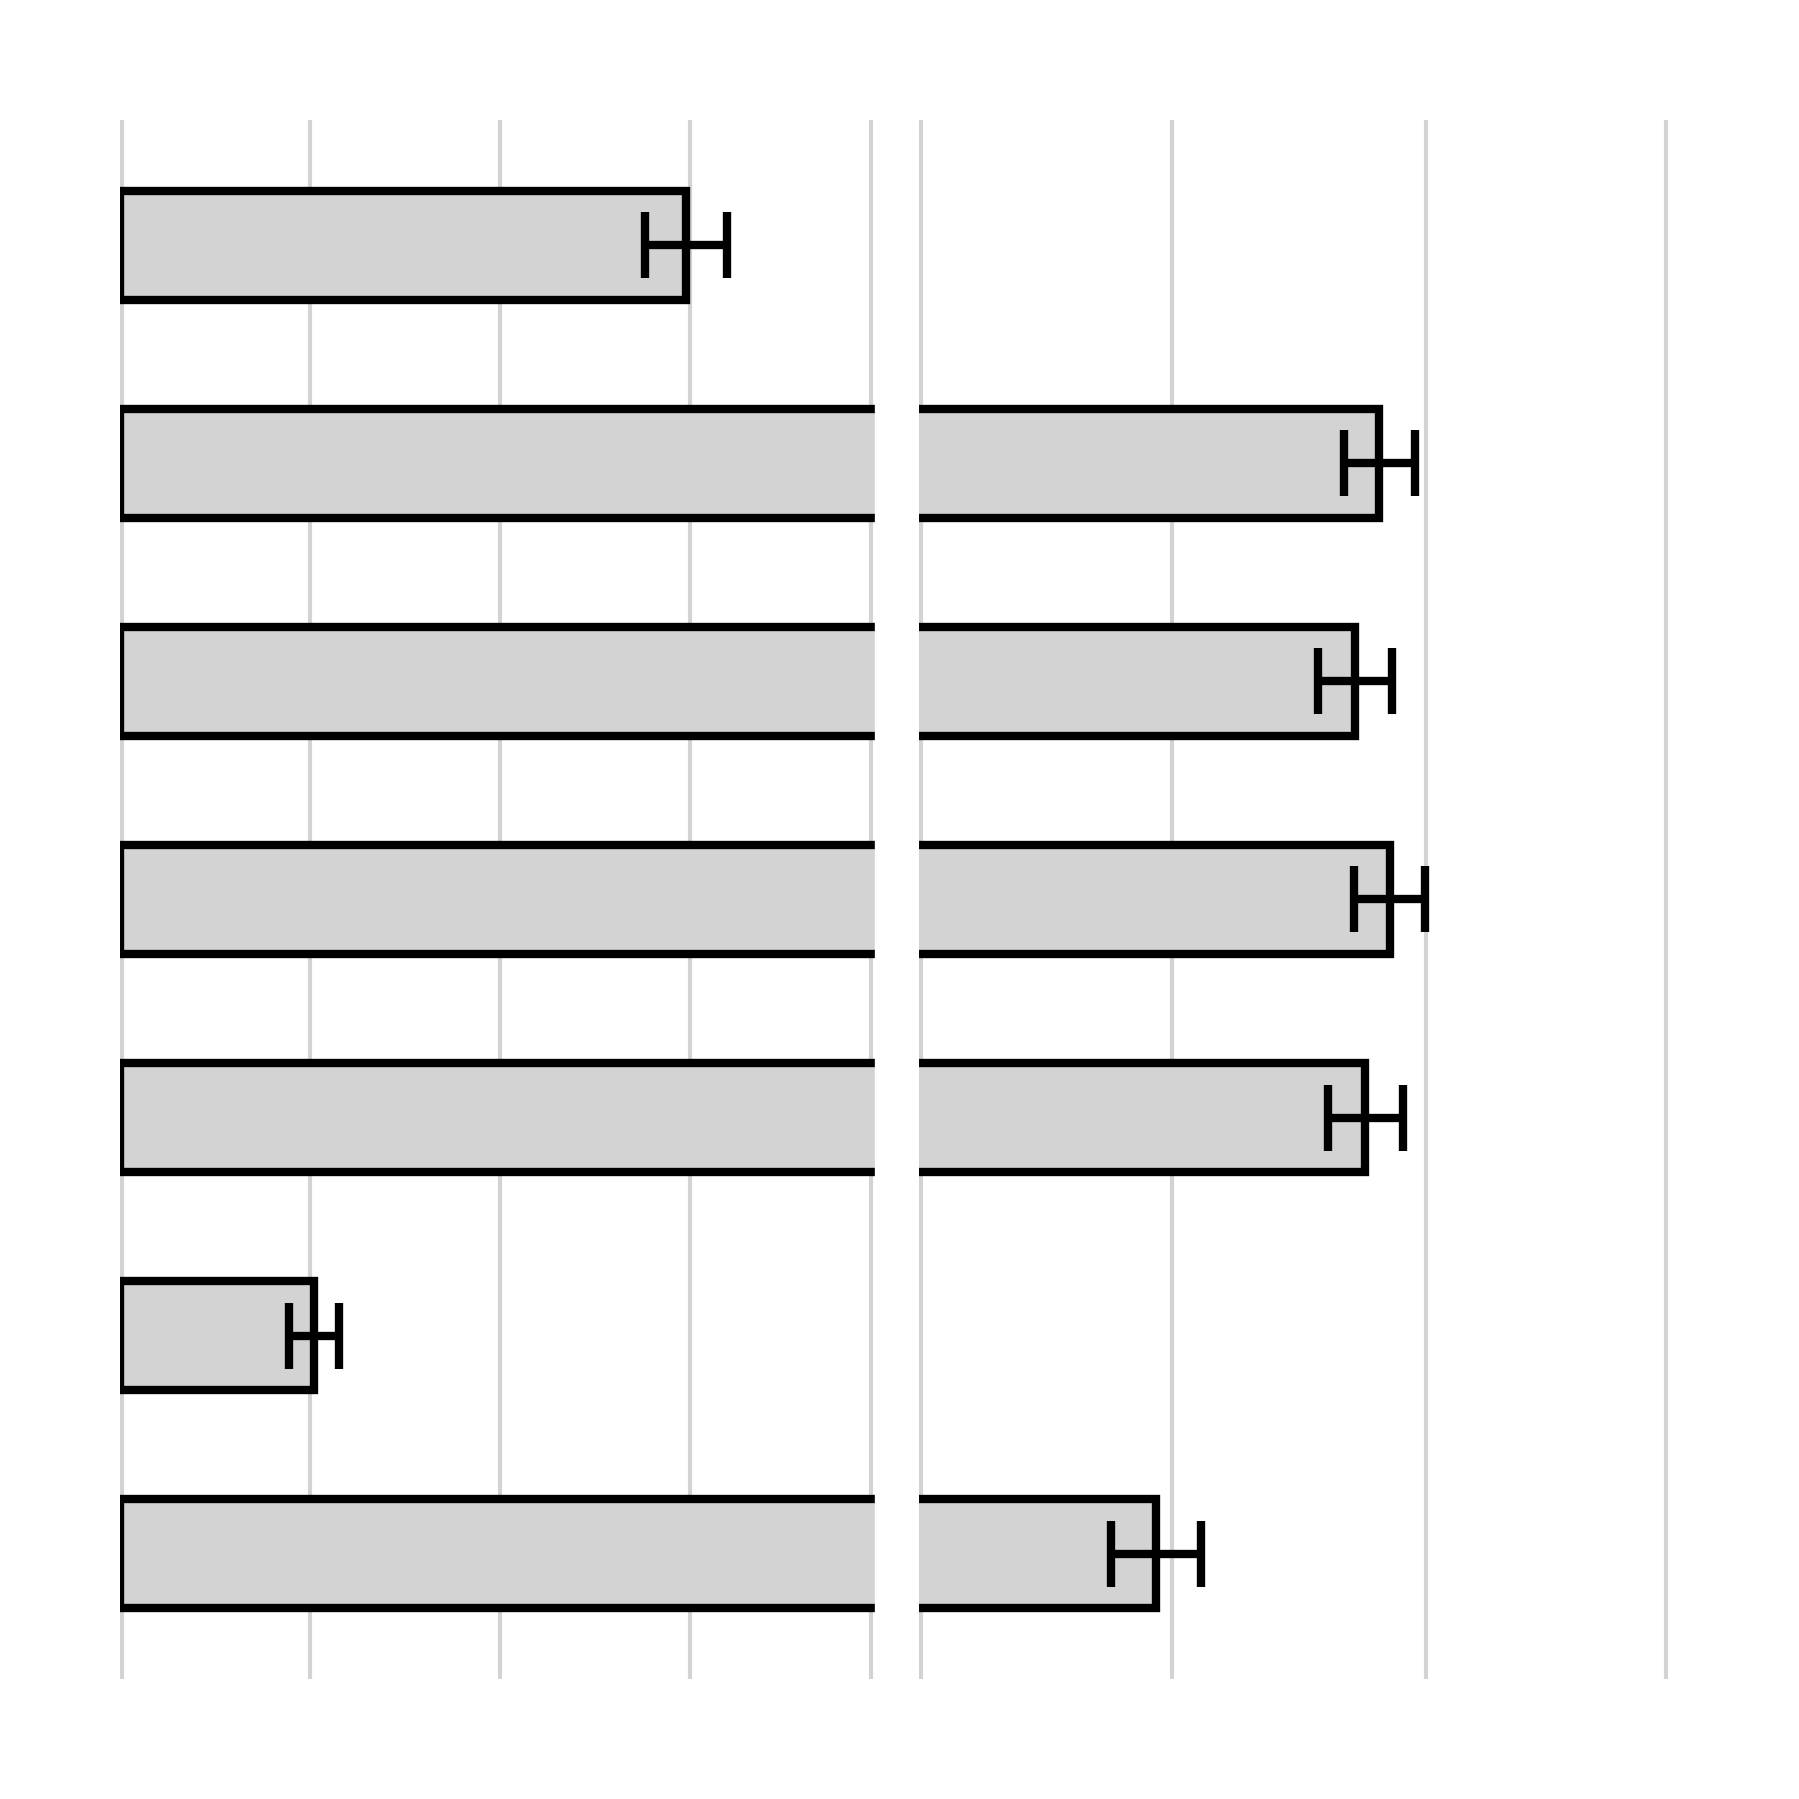

In [217]:
# Store accuracies and std for all experiments
all_accuracies = []
all_stds = []
labels = []

def bootstrap_accuracy(y_true, y_pred, n_iterations=1000):
    accuracies = []
    n_samples = len(y_true)
    
    for _ in range(n_iterations):
        # Random sampling with replacement
        indices = np.random.randint(0, n_samples, n_samples)
        boot_true = y_true.iloc[indices]
        boot_pred = y_pred.iloc[indices]
        
        # Calculate accuracy for this bootstrap sample
        accuracy = (boot_true == boot_pred).mean() * 100
        accuracies.append(accuracy)
    
    return np.mean(accuracies), np.std(accuracies)

for key in experiments.keys():
    # Load results
    results_df = pd.read_csv(f'/home/cm2161/Documents/llama-manufacturing/pr-intern/experiments/caxton/caxton_experiment_results_{key}.csv')
    
    if 'y_class' in results_df.columns and 'y_class_hat' in results_df.columns:
        # Calculate accuracy and std using bootstrapping
        mean_acc, std_acc = bootstrap_accuracy(
            results_df['y_class'], 
            results_df['y_class_hat']
        )
        all_accuracies.append(mean_acc)
        all_stds.append(std_acc)
        labels.append(f"ex.{key[-1]}")

# Create figure with broken axis
mm_to_inches = 0.0393701
fig_size_inches = 33 * mm_to_inches

fig, (ax1, ax2) = plt.subplots(1, 2, 
                              figsize=(fig_size_inches, fig_size_inches), 
                              dpi=1200,
                              gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})

# Plot in both axes with error bars
for ax in [ax1, ax2]:
    ax.barh(labels, all_accuracies, 
            height=0.5,
            xerr=all_stds,
            color='lightgrey',
            edgecolor='black',
            linewidth=0.5,
            error_kw={'ecolor': 'black', 
                     'capsize': 2, 
                     'capthick': 0.5, 
                     'elinewidth': 0.5})
    
    # Style plot
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()

# Add white spine between broken axes
ax1.spines['right'].set_visible(True)
ax1.spines['right'].set_color('white')

# Set different limits for each axis
ax1.set_xlim(0, 40)  # First segment shows 0-30
ax2.set_xlim(70, 100)  # Second segment shows 70-100

ax1.set_xticks([0.1, 10, 20, 30, 39.5])
ax1.set_xticklabels([])  # Remove x-axis labels
ax1.tick_params(axis='x', length=0)  # Remove tick marks
ax1.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1, zorder=0)
ax1.set_axisbelow(True)

ax2.set_xticks([70.1, 80, 90, 99.5])
ax2.set_xticklabels([])  # Remove x-axis labels
ax2.tick_params(axis='x', length=0)  # Remove tick marks
ax2.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1)
ax2.set_axisbelow(True)

# Replace plt.tight_layout(pad=0) with:
plt.subplots_adjust(
    left=0,    # Remove left margin
    right=1,   # Remove right margin
    bottom=0,  # Remove bottom margin
    top=1,     # Remove top margin
    wspace=0.1 # Keep small spacing between subplots
)
plt.show()

Experiments:   0%|                                                                                                                         | 0/7 [00:00<?, ?it/s]PTBTokenizer tokenized 6940 tokens at 99757.66 tokens per second.
PTBTokenizer tokenized 4287 tokens at 83294.75 tokens per second.
Experiments:  14%|████████████████▏                                                                                                | 1/7 [00:00<00:04,  1.42it/s]


Results for exp1:
CIDEr: 0.0002 ± 0.0010


PTBTokenizer tokenized 6774 tokens at 129707.17 tokens per second.
PTBTokenizer tokenized 4477 tokens at 90791.68 tokens per second.
Experiments:  29%|████████████████████████████████▎                                                                                | 2/7 [00:01<00:02,  1.87it/s]


Results for exp2:
CIDEr: 0.1895 ± 0.4900


PTBTokenizer tokenized 6940 tokens at 127957.75 tokens per second.
PTBTokenizer tokenized 3744 tokens at 76100.11 tokens per second.
Experiments:  43%|████████████████████████████████████████████████▍                                                                | 3/7 [00:01<00:01,  2.11it/s]


Results for exp3:
CIDEr: 0.0005 ± 0.0018


PTBTokenizer tokenized 6940 tokens at 130074.69 tokens per second.
PTBTokenizer tokenized 4249 tokens at 84070.71 tokens per second.
Experiments:  57%|████████████████████████████████████████████████████████████████▌                                                | 4/7 [00:01<00:01,  2.24it/s]


Results for exp4:
CIDEr: 0.0005 ± 0.0019


PTBTokenizer tokenized 6940 tokens at 132697.02 tokens per second.
PTBTokenizer tokenized 5002 tokens at 94867.18 tokens per second.
Experiments:  71%|████████████████████████████████████████████████████████████████████████████████▋                                | 5/7 [00:02<00:00,  2.29it/s]


Results for exp5:
CIDEr: 0.0001 ± 0.0005


PTBTokenizer tokenized 6940 tokens at 134584.87 tokens per second.
PTBTokenizer tokenized 3428 tokens at 71192.51 tokens per second.
Experiments:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6/7 [00:02<00:00,  2.39it/s]


Results for exp6:
CIDEr: 0.0640 ± 0.1292


PTBTokenizer tokenized 6940 tokens at 131497.22 tokens per second.
PTBTokenizer tokenized 3264 tokens at 70373.95 tokens per second.
Experiments: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]
/tmp/ipykernel_138182/1434620373.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(all_results['CIDEr']['data'],



Results for exp7:
CIDEr: 0.1233 ± 0.2098


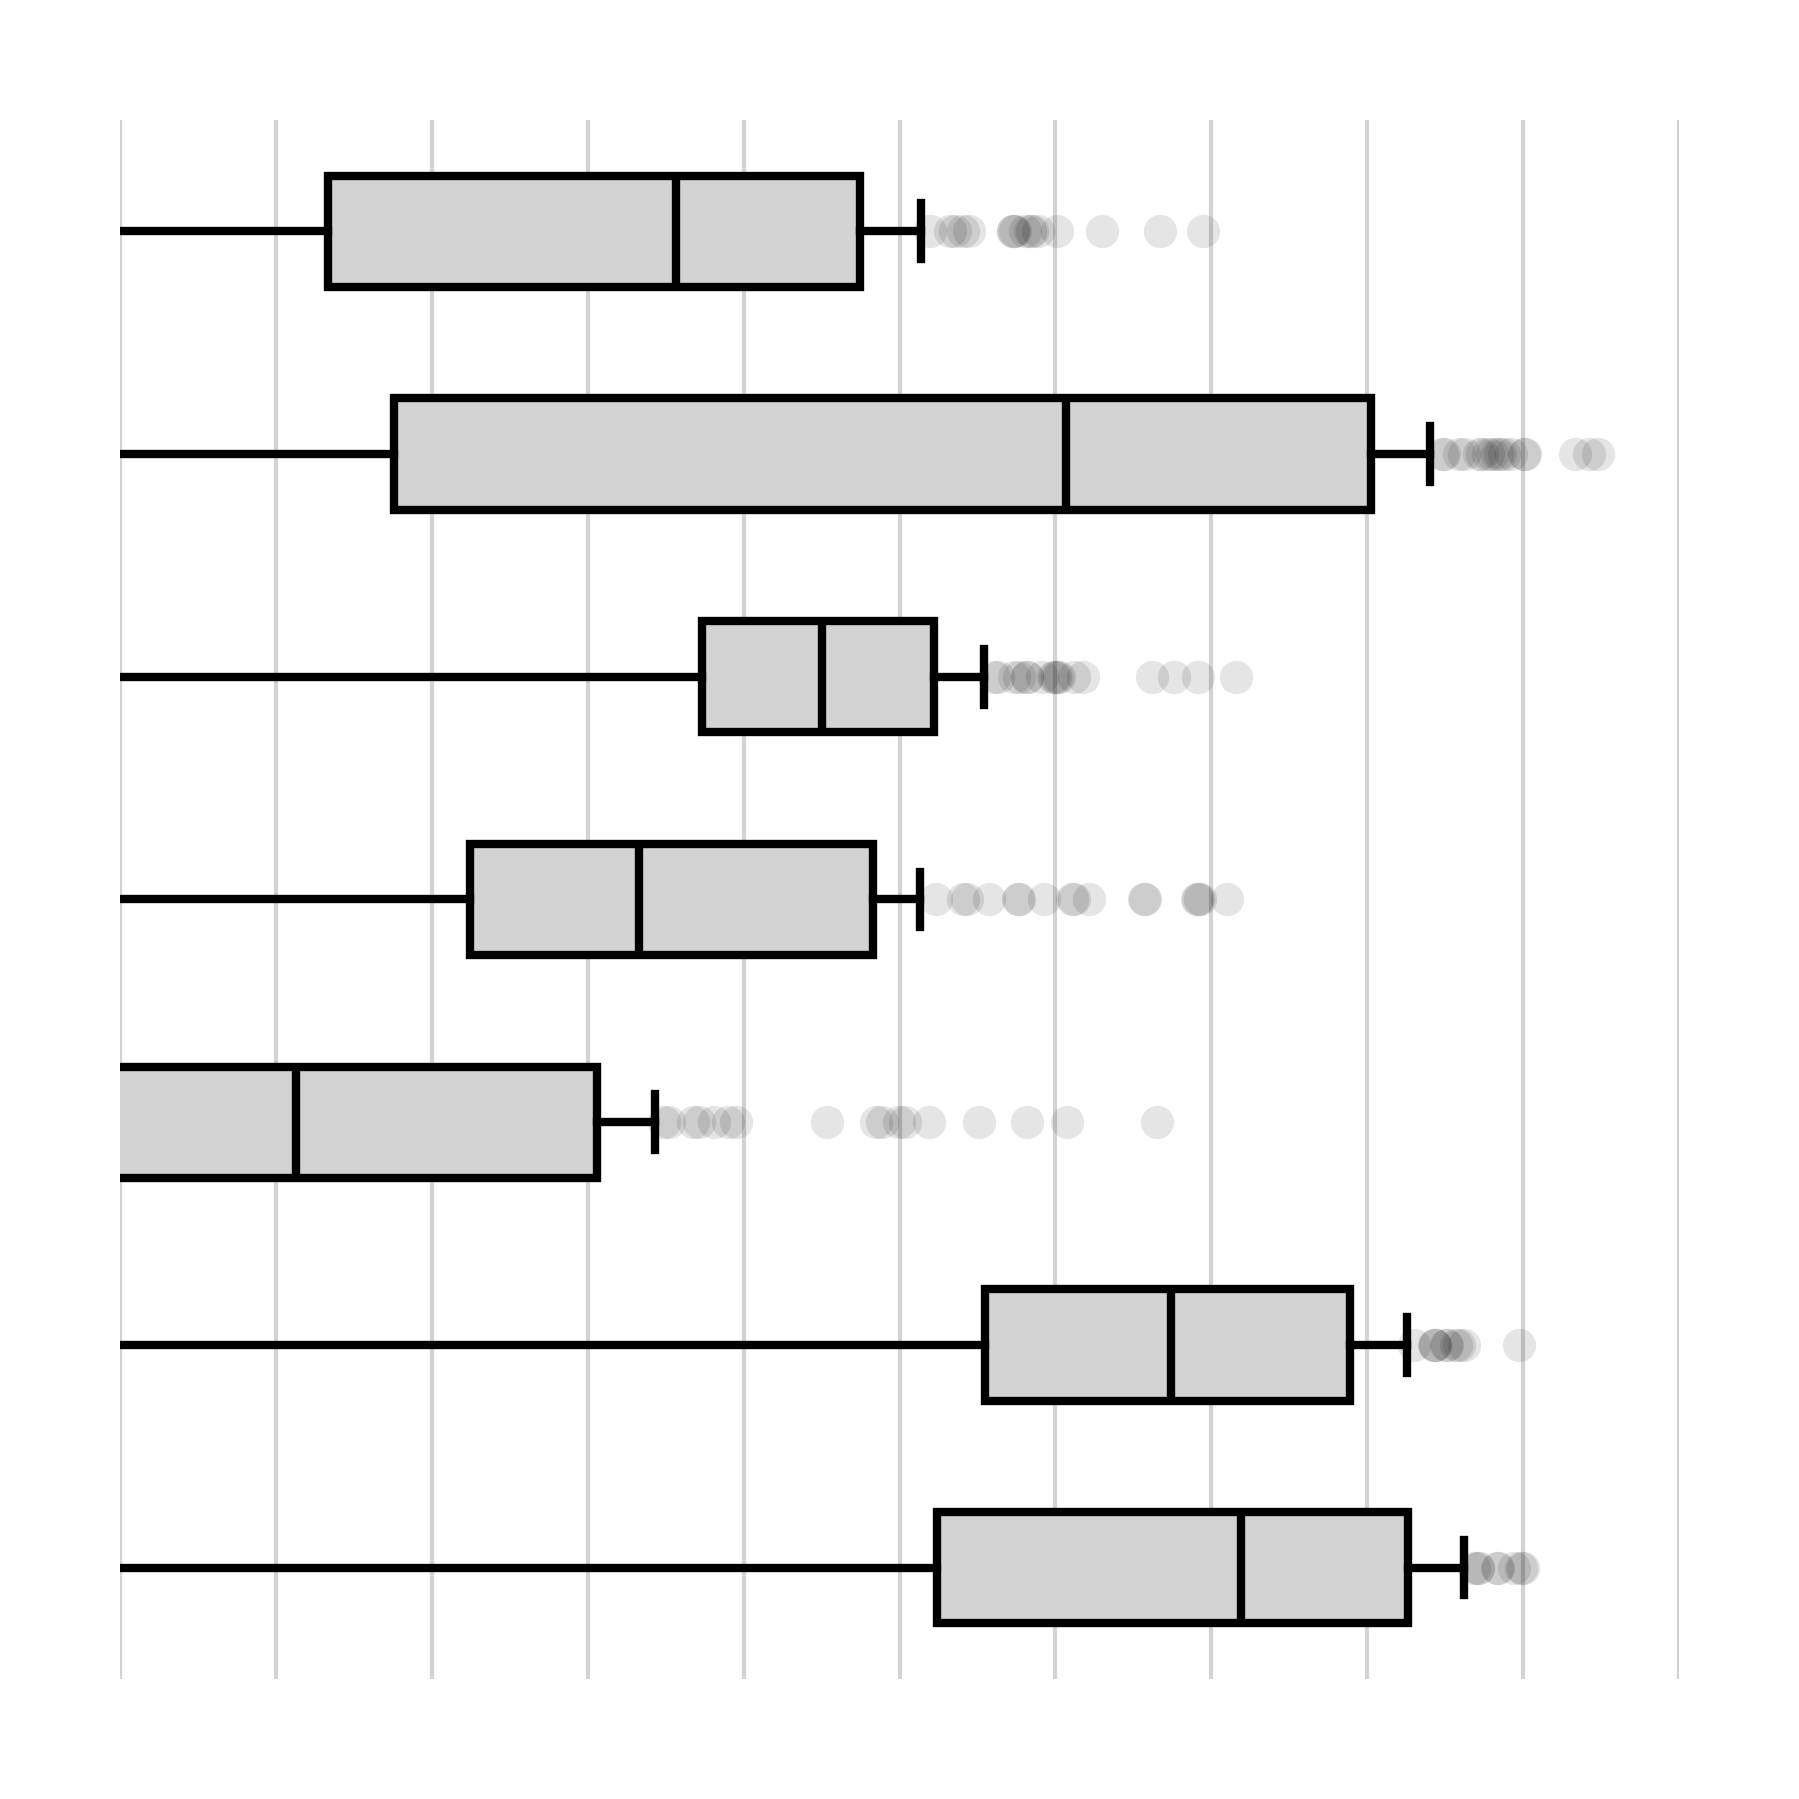

In [6]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.cider.cider import Cider
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

# Store results for CIDEr
all_results = {
    'CIDEr': {'data': [], 'labels': [], 'means': [], 'stds': []}
}

# Set up scorer
scorer = (Cider(), "CIDEr")

for key in tqdm(experiments.keys(), desc="Experiments"):
    # Load results
    results_df = pd.read_csv(f'/home/cm2161/Documents/llama-manufacturing/pr-intern/test_experiments/flickr/flickr_experiment_results_{key}.csv')
    
    # Convert string representation of list to actual list
    results_df['captions'] = results_df['captions'].apply(eval)
    
    # Clean data: remove rows with NaN or non-string answers
    results_df = results_df.dropna(subset=['answers', 'captions'])
    results_df['answers'] = results_df['answers'].astype(str)
    
    # Prepare data in COCO format
    gts = {}  # ground truth
    res = {}  # results
    for idx, row in results_df.iterrows():
        if not all(isinstance(cap, str) for cap in row['captions']):
            continue
            
        try:
            gts[idx] = [{'caption': str(cap)} for cap in row['captions']]
            res[idx] = [{'caption': str(row['answers'])}]
        except Exception as e:
            continue
    
    if not gts or not res:
        print(f"No valid data for {key}")
        continue

    # Set up tokenizer and tokenize for this experiment
    tokenizer = PTBTokenizer()
    gts_tokenized = tokenizer.tokenize(gts)
    res_tokenized = tokenizer.tokenize(res)
    
    # Calculate CIDEr score
    score, scores_list = scorer[0].compute_score(gts_tokenized, res_tokenized)
    all_results['CIDEr']['data'].append(scores_list)
    all_results['CIDEr']['labels'].append(f"ex.{key[-1]}")
    all_results['CIDEr']['means'].append(np.mean(scores_list))
    all_results['CIDEr']['stds'].append(np.std(scores_list))
            
    print(f"\nResults for {key}:")
    print(f"CIDEr: {score:.4f} ± {np.std(scores_list):.4f}")

# Create figure with two subplots side by side
mm_to_inches = 0.0393701
fig_size_inches = 33 * mm_to_inches

fig, (ax1) = plt.subplots(1, 1, figsize=(fig_size_inches, fig_size_inches), dpi=1200)

box_props = dict(
    boxprops=dict(facecolor='lightgrey', color='black', linewidth=0.5),
    whiskerprops=dict(color='black', linewidth=0.5),
    capprops=dict(color='black', linewidth=0.5),
    medianprops=dict(color='black', linewidth=0.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='black',
        markeredgecolor='none',
        alpha=0.1,
        markersize=2,
        linewidth=0.1
    ),
    # notch=True,
    # bootstrap=100,  # Increase bootstrap samples
    # conf_intervals=[[0.1, 0.2] for _ in range(len(all_results['CIDEr']['data']))],  # Widen confidence intervals
    patch_artist=True,
)
# Box plot
ax1.boxplot(all_results['CIDEr']['data'],
           labels=all_results['CIDEr']['labels'],
           vert=False,
           **box_props)

### switch to log scale at line ...

# Style box plot
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xscale('log')  # Set x-axis to logarithmic scale
ax1.set_xlim(0.000000001, 10)
ax1.set_yticks([])
ax1.invert_yaxis()

ax1.set_xticks([0.000000001, 0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01, 0.1, 1, 10])
ax1.set_xticklabels([])  # Remove x-axis labels
ax1.tick_params(axis='x', length=0)  # Remove tick marks
ax1.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1)

plt.tight_layout(pad=0)
plt.show()

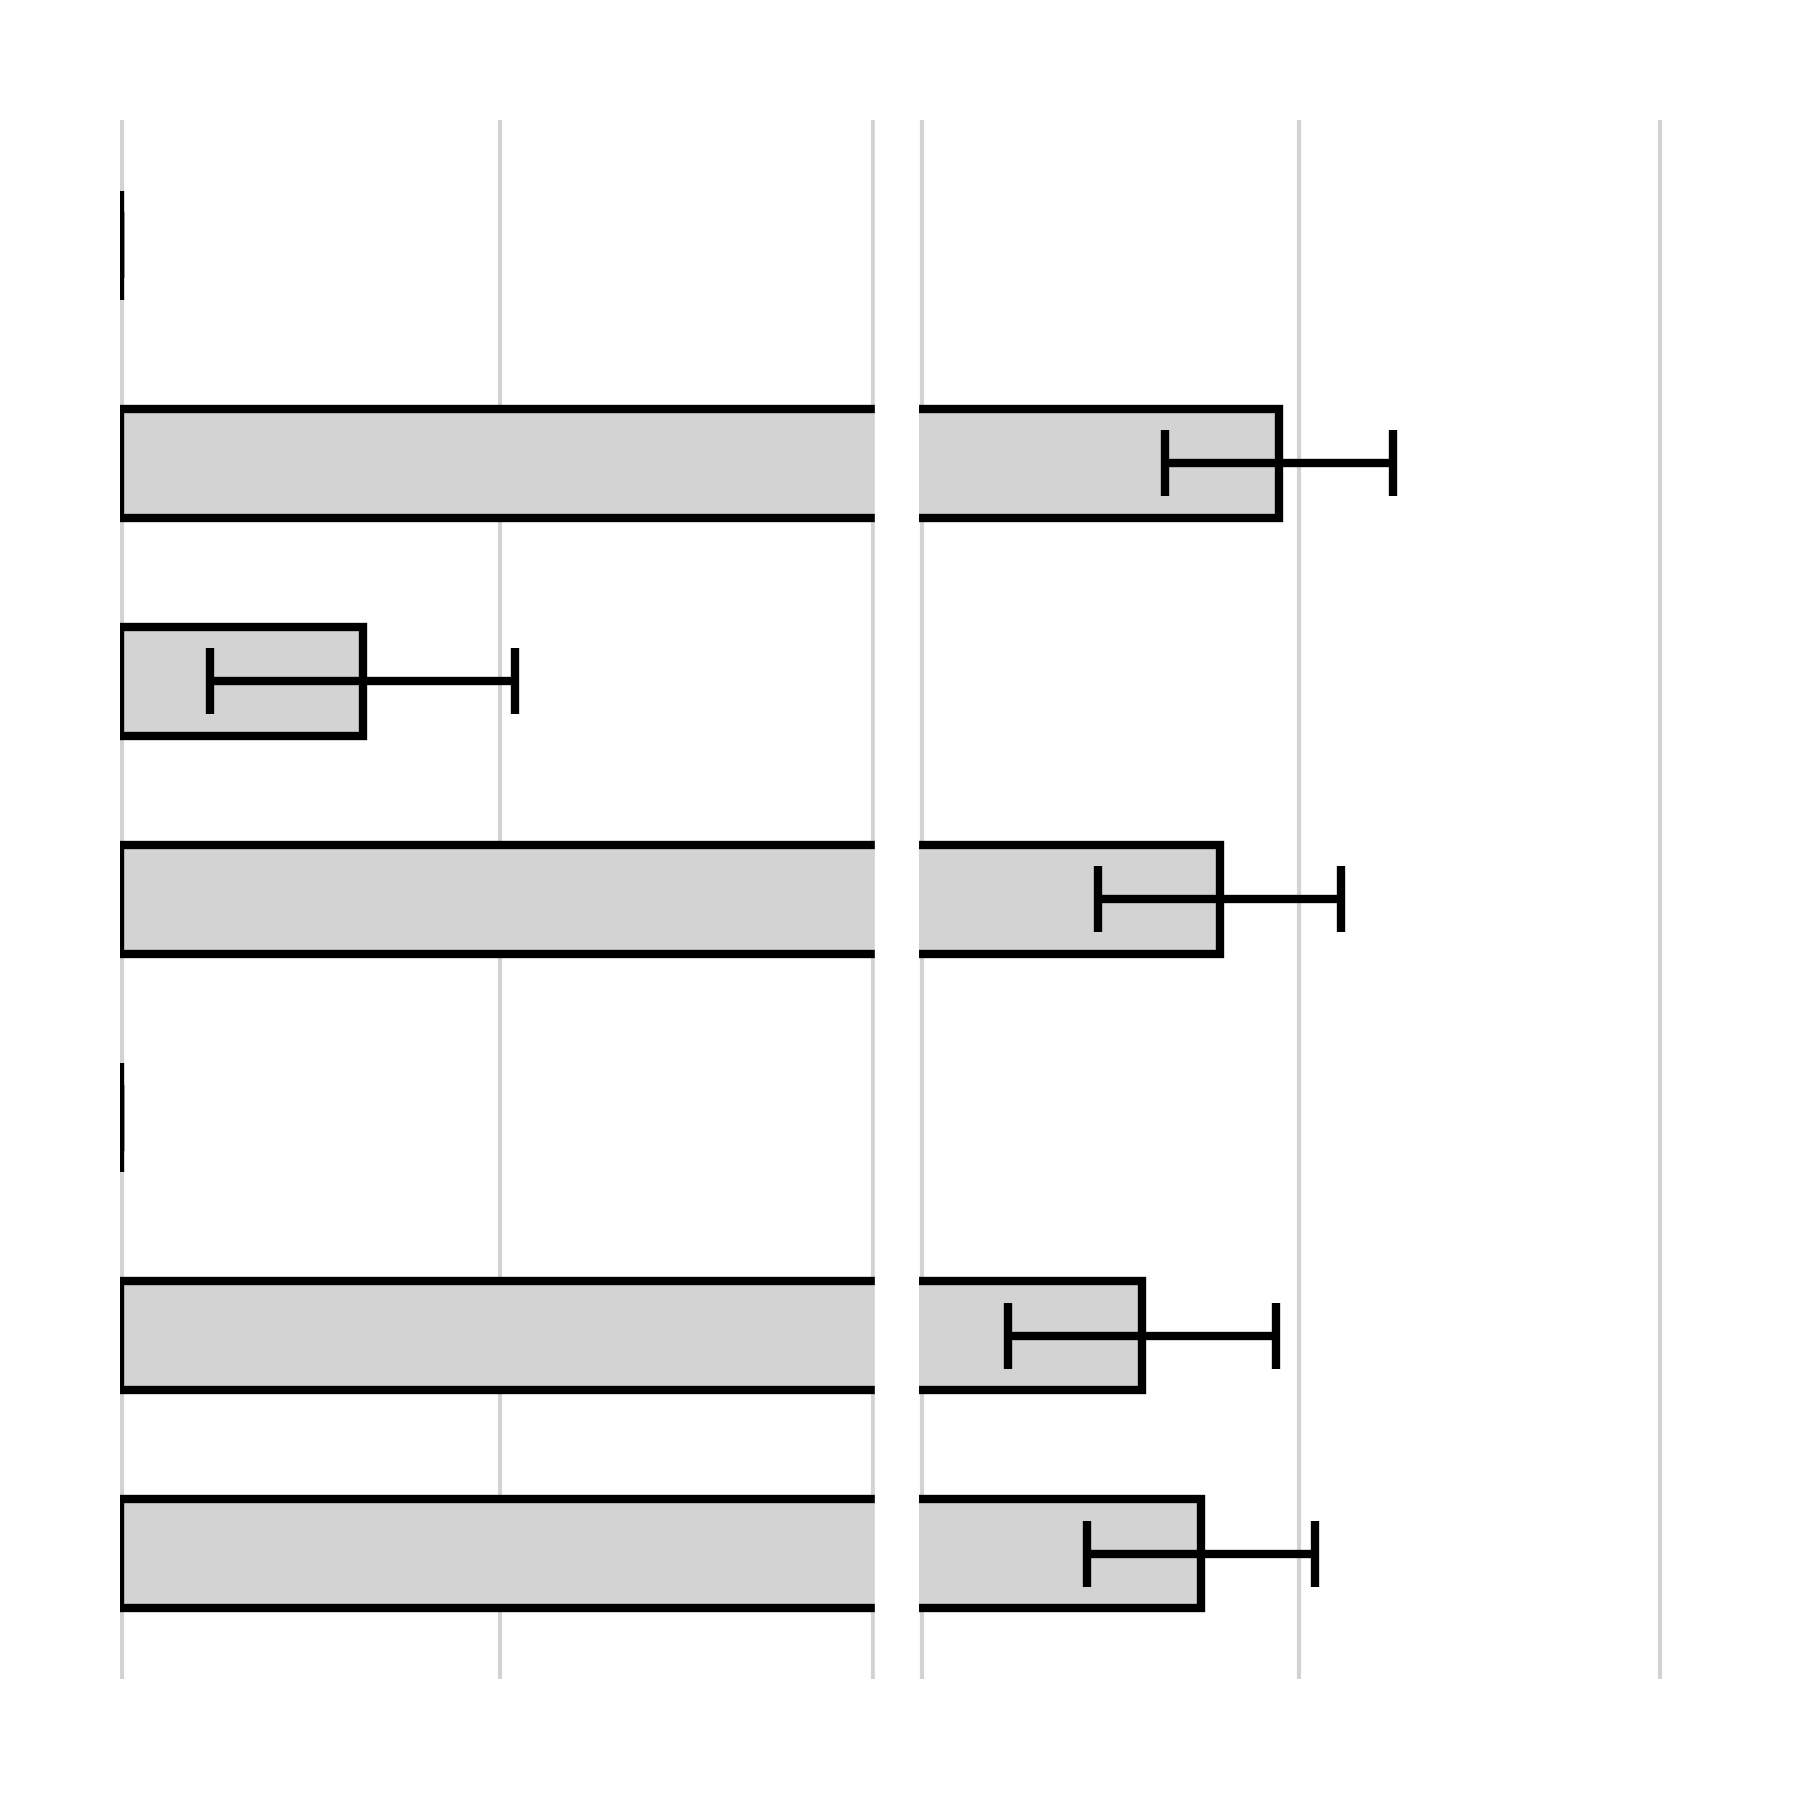

In [240]:
from collections import Counter
import string
import re
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def compute_recall(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    
    # Handle empty tokens case
    if len(gold_toks) == 0:
        return int(len(pred_toks) == 0)
    
    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    
    # Calculate recall: what fraction of correct tokens were predicted
    recall = 1.0 * num_same / len(gold_toks)
    return recall


# Add bootstrapping function
def bootstrap_metric(values, n_iterations=1000):
    """Calculate mean and std using bootstrapping"""
    bootstrap_means = []
    n_samples = len(values)
    
    for _ in range(n_iterations):
        # Random sampling with replacement
        indices = np.random.randint(0, n_samples, n_samples)
        bootstrap_sample = [values[i] for i in indices]
        bootstrap_means.append(np.mean(bootstrap_sample))
    
    return np.mean(bootstrap_means), np.std(bootstrap_means)


# Calculate bootstrapped means and stds for recall
recall_means = []
recall_stds = []

for key in experiments.keys():
    results_df = pd.read_csv(f'experiments/squad/squad_experiment_results_{key}.csv')
    
    recalls = []
    for _, row in results_df.iterrows():
        if pd.isna(row['answers']) or pd.isna(row['original_answers']):
            continue
            
        pred = row['answers']
        golds = eval(row['original_answers'])
        recall = max([compute_recall(gold, pred) for gold in golds])
        recalls.append(recall)
    
    mean, std = bootstrap_metric(recalls)
    recall_means.append(mean)
    recall_stds.append(std)

# Create figure
mm_to_inches = 0.0393701
fig_size_inches = 33 * mm_to_inches


fig, (ax1, ax2) = plt.subplots(1, 2, 
                              figsize=(fig_size_inches, fig_size_inches), 
                              dpi=1200,
                              gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})
# Get experiment labels
labels = [f"ex.{key[-1]}" for key in experiments.keys()]

# Plot in both axes with error bars
for ax in [ax1, ax2]:
    ax.barh(labels, 
            recall_means,
            height=0.5,
            xerr=recall_stds,
            color='lightgrey',
            edgecolor='black',
            linewidth=0.5,
            error_kw={'ecolor': 'black', 
                     'capsize': 2, 
                     'capthick': 0.5, 
                     'elinewidth': 0.5})
    
    # Style plot
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()

ax1.spines['right'].set_visible(True)
ax1.spines['right'].set_color('white')

# Set different limits for each axis
ax1.set_xlim(0, 0.1)  # First segment shows 0-0.05
ax2.set_xlim(0.8, 1)  # Second segment shows 0.80-1


ax1.set_xticks([0.0003, 0.05, 0.099])
ax1.set_xticklabels([])  # Remove x-axis labels
ax1.tick_params(axis='x', length=0)  # Remove tick marks
ax1.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1, zorder=0)
ax1.set_axisbelow(True)

ax2.set_xticks([0.801, 0.9, 0.995])
ax2.set_xticklabels([])  # Remove x-axis labels
ax2.tick_params(axis='x', length=0)  # Remove tick marks
ax2.grid(True, axis='x', linestyle='-', color='lightgrey', linewidth=0.25, alpha=1)
ax2.set_axisbelow(True)

# Replace plt.tight_layout(pad=0) with:
plt.subplots_adjust(
    left=0,    # Remove left margin
    right=1,   # Remove right margin
    bottom=0,  # Remove bottom margin
    top=1,     # Remove top margin
    wspace=0.1 # Keep small spacing between subplots
)
plt.show()